# BiLSTM SMS Spam Detection Streamlit app

In [1]:
#importing all the required libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, accuracy_score
import itertools


##Downloading the dataset

In [2]:
#download the spam.csv dataset from google drive.
!pip install gdown
import gdown

file_id = "1Uu9RwhrTFGAq_lAqQYNy9ok5i6DibrPA"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "spam.csv", quiet=False)



Downloading...
From: https://drive.google.com/uc?id=1Uu9RwhrTFGAq_lAqQYNy9ok5i6DibrPA
To: /content/spam.csv
100%|██████████| 504k/504k [00:00<00:00, 6.43MB/s]


'spam.csv'

## Preprocessing
- Reading the csv
- Keeping only the needed columns and renaming them.
- Lowercase them and reoving the special characters.
- Applying the cleaning to the messages.
- Label encoding.

In [3]:
df = pd.read_csv('spam.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['target', 'text']

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text

df['cleaned_text'] = df['text'].apply(clean_text)
df['target'] = df['target'].map({'ham': 0, 'spam': 1})


## Text modeling

- Splitting the data into training(80%) and test set (20%)
- Prepares word index for input texts.
- Fit tokenizer only on training set.
- Convert texts into input sequences.
- Pad all sequences to same length. i.e max_len= 100 in this case.

NOTE: max_words=5000 ➔ limits vocabulary to most frequent 5000 words — prevents overfitting, speeds up training.

oov_token="<OOV>" ➔ out-of-vocabulary handling (if unseen words come).

max_len=100 ➔ cuts or pads each SMS to 100 tokens — good for SMS data which usually is short.

In [4]:
from sklearn.model_selection import train_test_split

X = df['cleaned_text']
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

max_words = 5000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')


## BiLSTM Model

- Defining the BiLSTM architecture.
- Turns word indices into dense 40 dimensional vectors.
- Regularization i.e dropping random embedding features to prevent overfitting.
- BiLSTM laye with 100 units which would help in capturing the patterns from both past and future words.
- 'Sigmoid' as the activation in the final output layer: as it is binary classification.
- Compile the model.

NOTE:

EarlyStopping: If validation loss doesn’t improve for 3 epochs ➔ Stop early.

ModelCheckpoint: Save only the best model automatically (best_bilstm_model.keras).

Training settings:

10 epochs

Batch size 64

Validation set: Using the X_test_pad and y_test that you split earlier.

In [5]:
model = Sequential([
    Embedding(max_words, 40, input_length=max_len),
    SpatialDropout1D(0.3),
    Bidirectional(LSTM(100, dropout=0.3, recurrent_dropout=0.3)),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_bilstm_model.keras', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 55s 606ms/step - accuracy: 0.8616 - loss: 0.4249 - val_accuracy: 0.9561 - val_loss: 0.1733
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 43s 619ms/step - accuracy: 0.9677 - loss: 0.1157 - val_accuracy: 0.9758 - val_loss: 0.0900
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 80s 593ms/step - accuracy: 0.9863 - loss: 0.0546 - val_accuracy: 0.9803 - val_loss: 0.0736
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 580ms/step - accuracy: 0.9916 - loss: 0.0306 - val_accuracy: 0.9830 - val_loss: 0.0739
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 42s 595ms/step - accuracy: 0.9956 - loss: 0.0184 - val_accuracy: 0.9830 - val_loss: 0.0659
Epoch 6/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 83s 611ms/step - accuracy: 0.9963 - loss: 0.0147 - val_accuracy: 0.9803 - val_loss: 0.0730
Epoch 7/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 602ms/step - accuracy: 0.9972 - loss: 0.0109 - val_accuracy: 0.9830 - val_loss: 0.0756
Epoch 8/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 81s 595ms/step - accuracy: 0.9976 - loss: 0.0089 - val_accu

# Result

- A history object to plot the graphs (loss/accuracy over epochs).

- Confusion matrix (True label Vs Predicted label)

- Saved model (best_bilstm_model.keras) ready to upload in streamlit app.

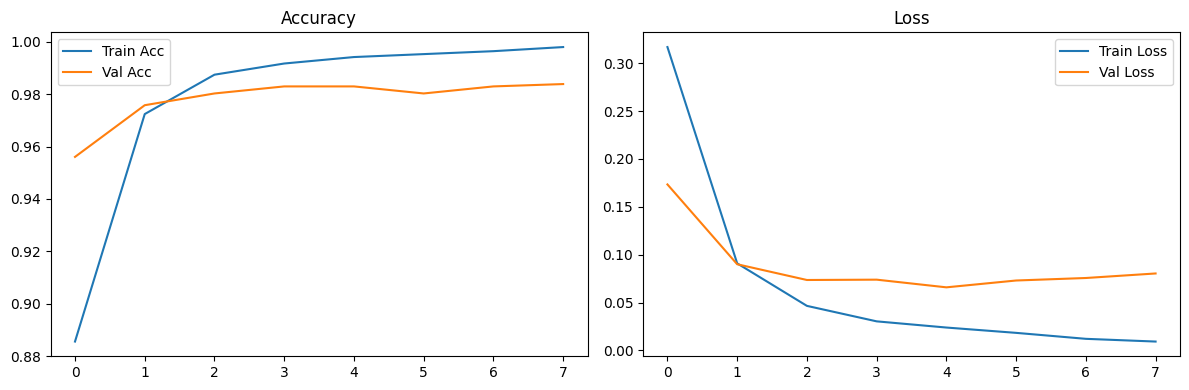

In [6]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Left side ➔ Training Accuracy vs Validation Accuracy per epoch

Right side ➔ Training Loss vs Validation Loss per epoch.


- We do this to check if the model is overfitting (train accuracy >> val accuracy)

- To check if the model is underfitting (both accuracies low)

Ideally, you want both training and validation accuracies to be close and high.

## You can visually confirm if your BiLSTM model is making too many errors or is working well using Confusion matrix.

Top left = True Ham

Bottom right = True Spam

Top right = Ham misclassified as Spam

Bottom left = Spam misclassified as Ham

35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step


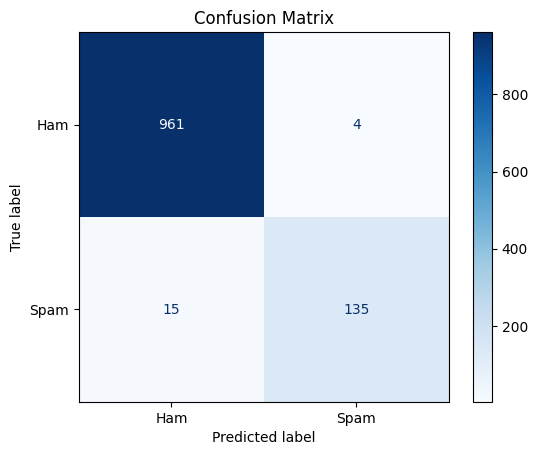

In [7]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


## Saving the trained tokenizer object into file using pickle.

In [8]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


* When the user enters a new SMS text in the Streamlit app, you need to tokenize and pad it the same way as during training.

* If you fit a new Tokenizer, the word indexes will be different — so you need to save and reload your original tokenizer.



Now, that we have,
- best_bilstm_model.keras → your trained BiLSTM model

- tokenizer.pkl → your trained tokenizer

We will be using this in streamlit